# RealNVP learns a toy 2D dataset
Refs: 1705.07057, 
https://github.com/ericjang/normalizing-flows-tutorial/blob/master/nf_part1_intro.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
layers = tf.contrib.layers

In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'batchSize': 1024,
    'numBijectors': 2,
    'trainIters': 1e5}

## 1. Collect data
Sample from distrution 
p(x1,x2) = N(x2|0,4) N(x1|1/4 x2^2 , 1)
where N is Gaussian

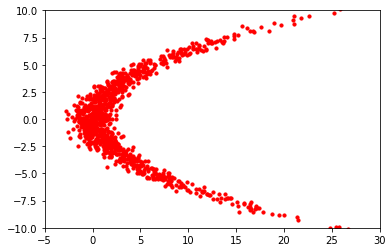

In [5]:
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(settings['batchSize'])
# Define a batch of scalar valued Normals. 
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples), scale=tf.ones(settings['batchSize'], dtype=DTYPE))
# Get 1 sample, returning a vector of size batch_size.
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)
# Evaluate graph and get ndarray
np_samples = sess.run(x_samples)
# Plot
plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10, color='red')
plt.xlim([-5, 30])
plt.ylim([-10, 10])
plt.savefig('example_2D_dataset.png', dpi=300)

## 2. Construct flow
Use tfb implementation of RealNVP

In [6]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [7]:
bijectors = []
for i in range(settings['numBijectors']):
    bijectors.append(tfb.RealNVP(
        num_masked=1,
        shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[512, 512]))) # MLP
    # permute coordinates
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [8]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

## 3. Visualize before training

In [9]:
# visualization (use batchSize samples)
x = base_dist.sample(settings['batchSize'])
samples = [x]
names = [base_dist.name]
# Need to reverse since list is inverted order
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [10]:
sess.run(tf.global_variables_initializer())

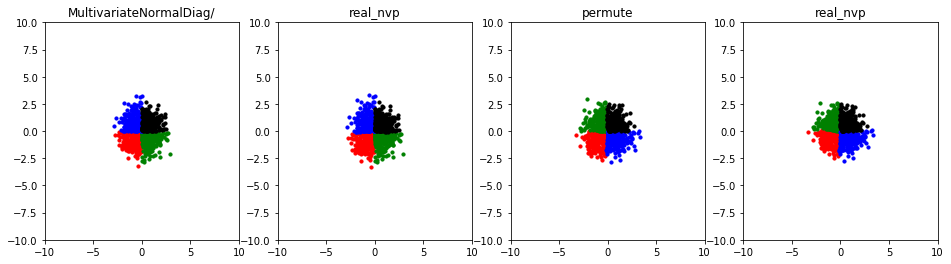

In [11]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

## 4. Optimize flow

In [12]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [13]:
sess.run(tf.global_variables_initializer())

0 35.107166
10000 4.1700664
20000 4.2285943
30000 4.223268
40000 4.203829
50000 4.2577076
60000 4.238599
70000 4.2592173
80000 4.190832
90000 4.231638


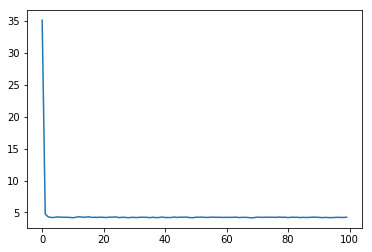

In [14]:
global_step = []
np_losses = []
for i in range(int(settings['trainIters'])):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

## 5. Visualize after training

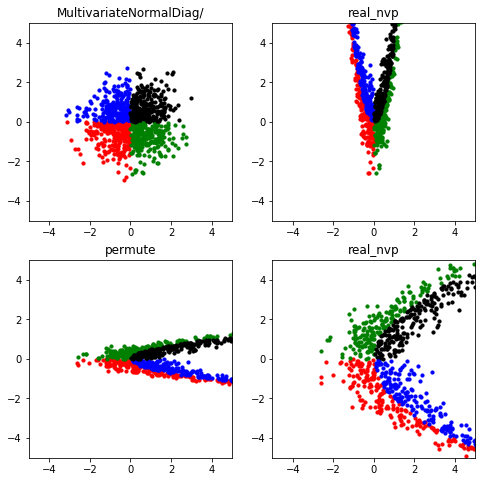

In [17]:
results = sess.run(samples)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('example_2D_RealNVP_learned.png', dpi=300)

Push back the X samples to get the base distribution. Good fit means Gaussian.

In [21]:
z = dist.bijector.inverse(x_samples)
result = sess.run(z)

(-4, 4)

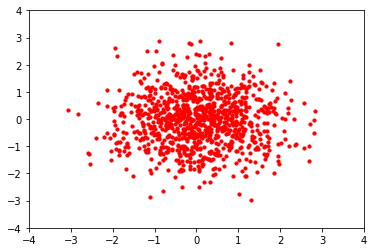

In [22]:
# Plot
plt.scatter(result[:, 0], result[:, 1], s=10, color='red')
plt.xlim([-4,4])
plt.ylim([-4,4])